# Load Model

In [235]:
import os
from tensorflow.keras.models import load_model
import numpy as np

save_dir = os.path.join("models", "save_experiments")
loaded_model = load_model(os.path.join(save_dir, "model.h5"))

loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frame_input (InputLayer)    [(None, 45, 1024)]           0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 45, 10)               51210     ['frame_input[0][0]']         
                                                                                                  
 batch_normalization_3 (Bat  (None, 45, 10)               40        ['conv1d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)   (None, 45, 10)               0         ['batch_normalization_3[

# Extract Feature from Video

In [236]:
import cv2
from feature_extractor import feature_extractor
# Reference: https://github.com/google/youtube-8m/tree/master/feature_extractor
# Note that the original module only works for TF 1.x but not 2.0,
# we need to modify the script specifically for tf.GraphDef, tf.Graph, and tf.Session to be
# tf.compat.v1.GraphDef tf.compat.v1.Graph and tf.compat.v1.Session, respectively.

CAP_PROP_POS_MSEC = 0

def frame_iterator(filename, every_ms=1000, max_num_frames=300):
    video_capture = cv2.VideoCapture()
    if not video_capture.open(filename):
        print >> sys.stderr, "Error: Cannot open video file " + filename
        return
    last_ts = -99999  # The timestamp of last retrieved frame.
    num_retrieved = 0
    while num_retrieved < max_num_frames:
        # Skip frames
        while video_capture.get(CAP_PROP_POS_MSEC) < every_ms + last_ts:
            if not video_capture.read()[0]:
                return
        last_ts = video_capture.get(CAP_PROP_POS_MSEC)
        has_frames, frame = video_capture.read()
        if not has_frames:
            break
        yield frame
        num_retrieved += 1

# Pre-trained ImageNet Inception model and PCA matrices will be downloaded if not found.
extractor = feature_extractor.YouTube8MFeatureExtractor("app/models")

def quantize(features, min_quantized_value=-2.0, max_quantized_value=2.0):
  """Quantizes float32 ⁠ features ⁠ into string."""
  assert features.dtype == 'float32'
  assert len(features.shape) == 1  # 1-D array
  features = np.clip(features, min_quantized_value, max_quantized_value)
  quantize_range = max_quantized_value - min_quantized_value
  features = (features - min_quantized_value) * (255.0 / quantize_range)
  features = [int(round(f)) for f in features]

  return features

In [322]:
video_file = "./Test_Video/Nature.mp4"  # A test sample.

rgb_features = []
sum_rgb_features = None

fiter = frame_iterator(video_file, every_ms=1000.0)

In [323]:
max_frames = 45  # Number of frames to extract

for _ in range(max_frames):
    frame = next(fiter, None)
    if frame is None:
        break
    features = extractor.extract_rgb_frame_features(frame[:, :, ::-1])
    features = quantize(features)
    rgb_features.append(features)

In [324]:
len(rgb_features) #(45,1024)
# rgb_features

45

In [325]:
# Convert the list to a numpy array
rgb_features_array = np.array(rgb_features)

# Reshape the array to add a new axis at the beginning
rgb_features_array = np.expand_dims(rgb_features_array, axis=0)

In [326]:
# Reshape the features into sequences of 45 frames each
predictions = loaded_model.predict(rgb_features_array)
print(predictions)

1/1 [==============================] - 0s 83ms/step
[[9.6454227e-01 1.3001478e-11 4.8575959e-11 2.2219159e-03 8.3171153e-01
  1.5696975e-13 9.9999982e-01 8.7349129e-01 2.1788758e-01 8.3311963e-01]]


In [332]:
label_dict = {0: 'Vehicle', 
              1: 'Concert', 
              2: 'Dance', 
              3: 'Football', 
              4: 'Animal', 
              5: 'Food', 
              6: 'Outdoor recreation', 
              7: 'Nature', 
              8: 'Mobile phone', 
              9: 'Cooking'}

predicted_labels = np.argmax(predictions, axis=1)

label_name = label_dict[predicted_labels[0]]
label_name

print(label_name)

Outdoor recreation


# Check Frame

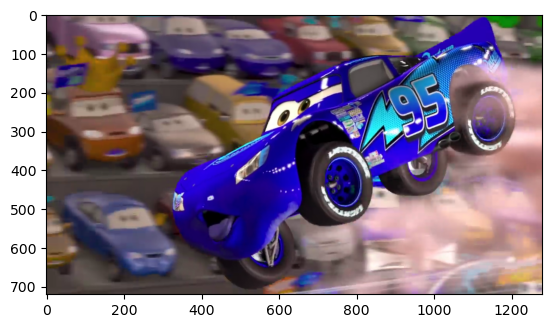

In [315]:
%matplotlib inline
import matplotlib.pyplot as plt

# Take just one frame.
next(fiter)
next(fiter)
next(fiter)
next(fiter)

rgb = next(fiter)

features = extractor.extract_rgb_frame_features(rgb[:, :, ::-1])

# Plot the extracted frame.
f = plt.imshow(rgb)

In [127]:
# The embeddings generated by the pre-trained Inception model on the above frame.
print(features.shape)
print(features)

(1024,)
[ 0.32068577 -0.00784719  1.0262779  ... -2.2360086   0.52385086
 -1.7608215 ]
